<center><img src="https://pure.ups.edu.ec/skin/headerImage/" width="300" height="300"></center>

<h1><center>Universidad Politecnica Salesiana</center></h1>
<h2><center>Simulacion Vacunacion con Recursos</center></h2>


<b>Nombre: </b> Javier Vazquez

<b>Materia: </b> Simulacion


### Simpy Recursos
Utilizando las tarea de la predicción de llegadas de vacunas y el recinto de vacunación, realizar un sistema que permita simular y correlacionar el procesos de llegada/compras de vacuna con el procesos de vacunación, en donde si no se tiene un stock/número de vacunas las personas tendran que esperar/reasignar a otro día en donde exista vacunas dentro del establecimiento y realizar el proceso de vacunación.

In [173]:
import simpy
import random 
import datetime as dt
from datetime import datetime

In [174]:
MESAS = 10 
TIEMPO_VACUNACION = 5
SEMANAS = 2
TIEMPO_SIMULACION =  SEMANAS *3*9*60
CONTROL_SIGNOS = 1
TIEMPO_POST_VACUNA = 20

tiempo_vacunacion={}
cont={0:1}
FECHA_ACTUAL = datetime.now().strftime('%d/%m/%Y')



### Variables auxiliares

In [175]:
personas_reasignadas={}
tiempo_vacunacion={}
estado_personas={}

## Definicion Clases  

La primera clase que definimos es la que va a ser nuestro Container, la cual va a tener almacenada las vacunas disponibles para ser utilizadas 

Con los metodos correspondiente, uno de ellos es el que va a estar constantemente verificando el estado del container y si en el caso que no encuentre stock este automaticamente llama un segundo metodo que se encarga de realizar la llamada al suministro de vacunas 

In [176]:
class VacunasEstado():
    def __init__(self, env):
        self.env = env
        self.dispensador = simpy.Resource(env, capacity=MESAS)
        self.bodega = simpy.Container(env, init=350, capacity=800)
        self.monitoreo = env.process(self.monitoreo_bodega())
    def monitoreo_bodega(self,):
        while True:
            if self.bodega.level <= 10:
                self.logs_procesos('++++','Solicitar nuevas vacunas ', self.env.now)
                env.process(self.solicitar_vacunas())
            yield self.env.timeout(15)
    def solicitar_vacunas(self,):
        yield self.env.timeout(50)
        self.logs_procesos('🚚💨','llega suministro vacunas ',self.env.now)
        nivel = self.bodega.capacity - self.bodega.level
        if nivel ==0:
            nivel+=1
        yield self.bodega.put(nivel)
        
    def logs_procesos(self,icon, accion, hora):
        print(" %s accion:  [%s] hora:  [%d] "%(icon, accion, hora))
        

La segunda clase definida es de la vacunacion la cual cuenta ya con metodos realizados en anteriores tareas, como:
* control de signos vitales
* aplicacion de vacuna
* tiempo de espera post vacuna



In [177]:
class Vacunacion():
    def __init__(self, env, nombre, estadoVacunas):
        self.env = env
        self.nombre = nombre 
        self.estado_vacunas = estadoVacunas
        self.proceso = env.process(self.proceso_vacunacion())
        self.personas_vacunadas = 0
    def control_signos(self):
        yield self.env.timeout(random.randint(CONTROL_SIGNOS, CONTROL_SIGNOS+2))
    
    def logs_procesos(self,icon,nombre, accion, hora):
        print(" %s nombre: [%s] accion:  [%s] hora:  [%d] "%(icon,nombre, accion, hora))
    
    def aplicar_vacuna(self):
        yield self.env.timeout(random.randint(TIEMPO_VACUNACION, TIEMPO_VACUNACION+5))
        
    def post_vacuna(self, tiempo):
        yield self.env.timeout(tiempo)
    
    def proceso_vacunacion(self,):
        while True:
            nombre= 'persona '+str(cont[0])
            cont[0]=cont[0]+1
            self.logs_procesos("--->",nombre," llega al recinto",self.env.now)
            estado_personas[nombre]='cola'
            yield env.process(self.control_signos())
            if random.randint(1,100) > 10:
                self.logs_procesos("🛂", nombre, "pasa el control", env.now)
                estado_personas[nombre]='pasa control'
                inicio_vacunacion =  self.env.now
                if self.estado_vacunas.bodega.level >=1:
                    yield env.process(self.aplicar_vacuna())
                    estado_personas[nombre]='vacunado'
                    self.estado_vacunas.bodega.get(1)
                    tiempo_vacunacion[nombre] = self.env.now - inicio_vacunacion
                    self.logs_procesos("💉", nombre, "fue vacunada ", self.env.now)
                    yield env.process(self.post_vacuna(TIEMPO_POST_VACUNA))
                    self.logs_procesos("✅", nombre, "sin complicaciones", self.env.now)
                    self.personas_vacunadas += 1
                    estado_personas[nombre]='completo'
                    
                else:
                    prox_cita = datetime.strftime(datetime.strptime(FECHA_ACTUAL, '%d/%m/%Y')+dt.timedelta(days=3), '%d/%m/%Y')
                    print("--XX-- No hay vacunas para %s, reasignado fecha para: %s"%(nombre, prox_cita))
                    personas_reasignadas[nombre]='reasignado'
                    estado_personas[nombre]='reasignado'
                                
            else:
                self.logs_procesos("❌", nombre,"no pasa el control", self.env.now)
                estado_personas[nombre]='no control'

### Ejecutar simulacion 

Primero declaramos el estado de las vacunas, el cual va a ser un proceso que esta ejecutandose de manera paralela al procesos de vacunacion, donde constantemente se encuentra verificando que exista stock de vacunas 

Mientras para la vacunacion se el pasa esta clase estadoVacunas de donde podremos consumir del container(bodega vacunas) las vacunas necesarias para aplicar a los pacientes, y si en el caso que ya no exista vacunas al paciente se le reasignara la fecha para la siguiente jornada de vacunacion que es en 3 dias posteriores 

In [178]:
env = simpy.Environment()

vacunasEstado = VacunasEstado(env)
vacunacion =[Vacunacion(env,"Mesa %d"% i, vacunasEstado) for i in range(MESAS)]
env.run(until=TIEMPO_SIMULACION)
print("Simulacion realizada despues de %d semanas"%SEMANAS)
for i in vacunacion:
    print("[%s] ha vacunado a [%d] personas"%(i.nombre,i.personas_vacunadas))

 ---> nombre: [persona 1] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 2] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 3] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 4] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 5] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 6] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 7] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 8] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 9] accion:  [ llega al recinto] hora:  [0] 
 ---> nombre: [persona 10] accion:  [ llega al recinto] hora:  [0] 
 ❌ nombre: [persona 1] accion:  [no pasa el control] hora:  [1] 
 ---> nombre: [persona 11] accion:  [ llega al recinto] hora:  [1] 
 🛂 nombre: [persona 2] accion:  [pasa el control] hora:  [1] 
 🛂 nombre: [persona 5] accion:  [pasa el control] hora:  [1] 
 🛂 nombre: [persona 9] accion:  [pasa el control] hora:  [1] 
 🛂 nombre:

 🛂 nombre: [persona 297] accion:  [pasa el control] hora:  [780] 
 ✅ nombre: [persona 286] accion:  [sin complicaciones] hora:  [781] 
 ---> nombre: [persona 298] accion:  [ llega al recinto] hora:  [781] 
 💉 nombre: [persona 292] accion:  [fue vacunada ] hora:  [782] 
 💉 nombre: [persona 293] accion:  [fue vacunada ] hora:  [784] 
 🛂 nombre: [persona 298] accion:  [pasa el control] hora:  [784] 
 💉 nombre: [persona 295] accion:  [fue vacunada ] hora:  [785] 
 ✅ nombre: [persona 287] accion:  [sin complicaciones] hora:  [786] 
 ---> nombre: [persona 299] accion:  [ llega al recinto] hora:  [786] 
 💉 nombre: [persona 294] accion:  [fue vacunada ] hora:  [786] 
 ✅ nombre: [persona 289] accion:  [sin complicaciones] hora:  [787] 
 ---> nombre: [persona 300] accion:  [ llega al recinto] hora:  [787] 
 💉 nombre: [persona 297] accion:  [fue vacunada ] hora:  [788] 
 🛂 nombre: [persona 299] accion:  [pasa el control] hora:  [789] 
 🛂 nombre: [persona 300] accion:  [pasa el control] hora:  [78

 ---> nombre: [persona 567] accion:  [ llega al recinto] hora:  [1411] 
 💉 nombre: [persona 561] accion:  [fue vacunada ] hora:  [1411] 
 🛂 nombre: [persona 564] accion:  [pasa el control] hora:  [1411] 
 🛂 nombre: [persona 566] accion:  [pasa el control] hora:  [1412] 
 🛂 nombre: [persona 567] accion:  [pasa el control] hora:  [1412] 
 ✅ nombre: [persona 557] accion:  [sin complicaciones] hora:  [1415] 
 ---> nombre: [persona 568] accion:  [ llega al recinto] hora:  [1415] 
 ✅ nombre: [persona 559] accion:  [sin complicaciones] hora:  [1416] 
 ---> nombre: [persona 569] accion:  [ llega al recinto] hora:  [1416] 
 🛂 nombre: [persona 568] accion:  [pasa el control] hora:  [1417] 
 ✅ nombre: [persona 556] accion:  [sin complicaciones] hora:  [1418] 
 ---> nombre: [persona 570] accion:  [ llega al recinto] hora:  [1418] 
 💉 nombre: [persona 566] accion:  [fue vacunada ] hora:  [1418] 
 🛂 nombre: [persona 569] accion:  [pasa el control] hora:  [1418] 
 💉 nombre: [persona 565] accion:  [fu

 🛂 nombre: [persona 782] accion:  [pasa el control] hora:  [1983] 
 ✅ nombre: [persona 772] accion:  [sin complicaciones] hora:  [1984] 
 ---> nombre: [persona 783] accion:  [ llega al recinto] hora:  [1984] 
 💉 nombre: [persona 781] accion:  [fue vacunada ] hora:  [1984] 
 ✅ nombre: [persona 773] accion:  [sin complicaciones] hora:  [1985] 
 ---> nombre: [persona 784] accion:  [ llega al recinto] hora:  [1985] 
 💉 nombre: [persona 779] accion:  [fue vacunada ] hora:  [1985] 
 💉 nombre: [persona 780] accion:  [fue vacunada ] hora:  [1985] 
 🛂 nombre: [persona 783] accion:  [pasa el control] hora:  [1985] 
 💉 nombre: [persona 782] accion:  [fue vacunada ] hora:  [1988] 
 🛂 nombre: [persona 784] accion:  [pasa el control] hora:  [1988] 
 ✅ nombre: [persona 775] accion:  [sin complicaciones] hora:  [1992] 
 ---> nombre: [persona 785] accion:  [ llega al recinto] hora:  [1992] 
 ✅ nombre: [persona 776] accion:  [sin complicaciones] hora:  [1992] 
 ---> nombre: [persona 786] accion:  [ lleg

 ---> nombre: [persona 1009] accion:  [ llega al recinto] hora:  [2594] 
 ✅ nombre: [persona 999] accion:  [sin complicaciones] hora:  [2595] 
 ---> nombre: [persona 1010] accion:  [ llega al recinto] hora:  [2595] 
 💉 nombre: [persona 1005] accion:  [fue vacunada ] hora:  [2595] 
 🛂 nombre: [persona 1009] accion:  [pasa el control] hora:  [2595] 
 💉 nombre: [persona 1007] accion:  [fue vacunada ] hora:  [2596] 
 💉 nombre: [persona 1008] accion:  [fue vacunada ] hora:  [2596] 
 🛂 nombre: [persona 1010] accion:  [pasa el control] hora:  [2596] 
 ✅ nombre: [persona 1001] accion:  [sin complicaciones] hora:  [2597] 
 ---> nombre: [persona 1011] accion:  [ llega al recinto] hora:  [2597] 
 ✅ nombre: [persona 1002] accion:  [sin complicaciones] hora:  [2597] 
 ---> nombre: [persona 1012] accion:  [ llega al recinto] hora:  [2597] 
 🛂 nombre: [persona 1012] accion:  [pasa el control] hora:  [2598] 
 🛂 nombre: [persona 1011] accion:  [pasa el control] hora:  [2600] 
 💉 nombre: [persona 1009] 

## Resultados 

In [179]:
no_control=[key for key in list(estado_personas.keys()) if estado_personas[key]=='no control']
vacunados=[key for key in list(estado_personas.keys()) if estado_personas[key]=='completo']
reasignados=[key for key in list(estado_personas.keys()) if estado_personas[key]=='reasignado']
print('-'*70,'\nTotal personas: ', len(estado_personas))
print('Personas que no pasaron el control: ', len(no_control))
print('Personas vacunadas: ', len(vacunados))
print('Personas que fueron reasignados por falta de stock: ', len(reasignados))

---------------------------------------------------------------------- 
Total personas:  1251
Personas que no pasaron el control:  123
Personas vacunadas:  1080
Personas que fueron reasignados por falta de stock:  38


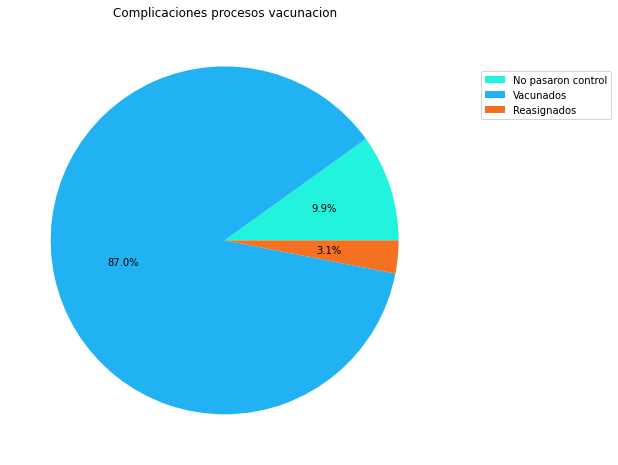

In [180]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.pie([len(no_control), len(vacunados), len(reasignados)],colors=['#21F3DC','#21B2F3','#F37121'],autopct='%1.1f%%')
plt.legend(['No pasaron control','Vacunados','Reasignados'],bbox_to_anchor=(0.9, 0, 0.5, 0.9))
plt.title('Complicaciones procesos vacunacion')
plt.show()